In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [16]:
df = pd.read_csv('BTCUSDTnew-3m.csv')
df

,open_time,open,high,low,close,volume,num_trades,taker_base_vol
0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4280.56,2.036257,5,0.336257
1,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.152804,4,0.152804
2,2017-08-17 04:06:00,4261.48,4261.48,4261.48,4261.48,0.000000,0,0.000000
3,2017-08-17 04:09:00,4261.48,4261.48,4261.48,4261.48,0.000000,0,0.000000
4,2017-08-17 04:12:00,4261.48,4261.48,4261.48,4261.48,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...
1114305,2023-12-31 14:39:00,42503.07,42525.80,42503.06,42509.55,17.955380,1561,9.193300
1114306,2023-12-31 14:42:00,42509.54,42513.77,42481.96,42513.76,27.821180,1688,17.813370
1114307,2023-12-31 14:45:00,42513.76,42526.36,42491.10,42496.53,27.652450,2265,11.661380
1114308,2023-12-31 14:48:00,42496.54,42523.67,42496.53,42504.01,29.552500,1672,15.450590


Keeeping only open_time and close

In [17]:
df = df[['open_time', 'close']]

Converting open_time to datetime

In [18]:
df['open_time'] = pd.to_datetime(df['open_time'])

C:\Users\sanya\AppData\Local\Temp\ipykernel_12556\1031759263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['open_time'] = pd.to_datetime(df['open_time'])


In [19]:
df.index = df.pop('open_time')
df.head(2)

,close
open_time,
2017-08-17 04:00:00,4280.56
2017-08-17 04:03:00,4261.48


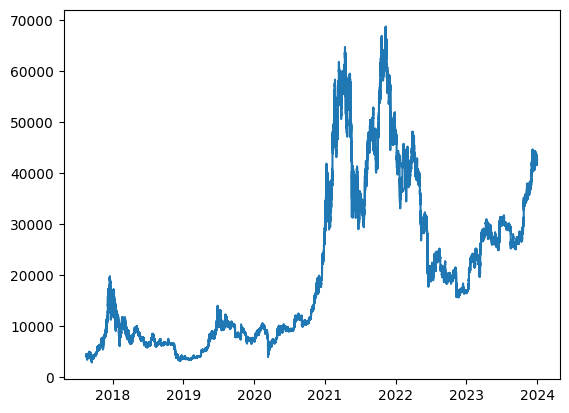

In [20]:
plt.plot(df.index, df['close'])

In [21]:
# Making the dataset between the required time frame
start_date = datetime.datetime(year=2018,month=1,day=1)
end_date = datetime.datetime(year=2022,month=1,day=31)
df = df.loc[(df.index >= start_date) & (df.index <= end_date)]
df.head(1)

,close
open_time,
2018-01-01,13680.0


In [24]:
def add_previous_close_columns(df, n):
    for i in range(1, n+1):
        df[f'close_{i}_prev'] = df['close'].shift(i)
    # Dropping first 3 columns due to null values
    df = df.drop(df.index[:n])
    # Reversing the column order
    df = df.iloc[:, ::-1]
    return df

WINDOW_SIZE = 60  # Set the number of previous 'close' values you want to include
df = add_previous_close_columns(df, WINDOW_SIZE)
# df.head()

In [25]:
def windowed_df_to_date_X_y(windowed_dataframe):
  dates = windowed_dataframe.index

  df_as_np = windowed_dataframe.to_numpy()

  middle_matrix = df_as_np[:, 0:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(df)

dates.shape, X.shape, y.shape

((712957,), (712957, 60, 1), (712957,))

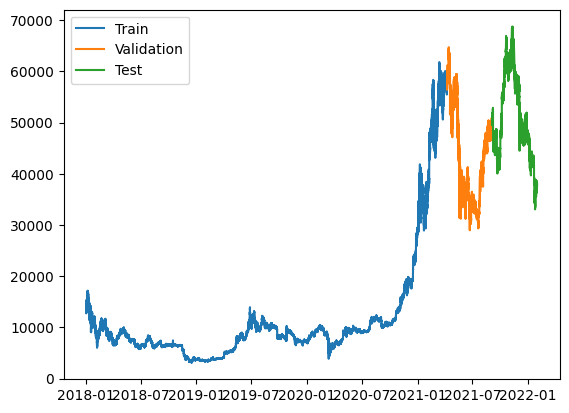

In [26]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [27]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Bidirectional, LSTM

In [31]:
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True,input_shape=(WINDOW_SIZE, 1))))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dense(25))
model.add(Dense(1))

model.build(input_shape=(None, WINDOW_SIZE, 1))

model.compile(loss='mean_squared_error',
              optimizer=Adam(),
              metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 60, 100)          20800     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 25)                2525      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 83,751
Trainable params: 83,751
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
17824/17824 [==============================] - 504s 27ms/step - loss: 130885624.0000 - mean_absolute_error: 6627.1055 - val_loss: 1077065600.0000 - val_mean_absolute_error: 31496.6465
Epoch 2/10
17824/17824 [==============================] - 490s 27ms/step - loss: 124912024.0000 - mean_absolute_error: 6493.2534 - val_loss: 1080241664.0000 - val_mean_absolute_error: 31547.0625
Epoch 3/10
17824/17824 [==============================] - 478s 27ms/step - loss: 124914816.0000 - mean_absolute_error: 6493.2490 - val_loss: 1082930048.0000 - val_mean_absolute_error: 31589.6621
Epoch 4/10
17824/17824 [==============================] - 497s 28ms/step - loss: 124911480.0000 - mean_absolute_error: 6492.2197 - val_loss: 1076952448.0000 - val_mean_absolute_error: 31494.8945
Epoch 5/10
17824/17824 [==============================] - 504s 28ms/step - loss: 124912568.0000 - mean_absolute_error: 6492.9883 - val_loss: 1081335936.0000 - val_mean_absolute_error: 31564.4160
Epoch 6/10
17824/17824 [=

17824/17824 [==============================] - 194s 11ms/step


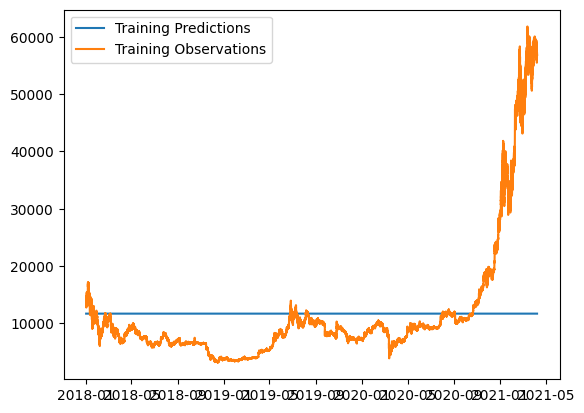

In [33]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

In [34]:
model.save("BTC_LSTM.h5")

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])